In [6]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np

In [7]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Represents the different types of Cells
class Cell(Enum):
    BLOCKED = 0
    OPEN = 1
    FIRE = 2
    BUTTON = 3

    def __eq__(self, other):
        if isinstance(other, Cell):
            return self.value == other.value
        return self.value == other
    
# Represents the Ship
class Ship: 
    def __init__(self, D):
        self.D = D
        self.board = []
        self.open_cells = []
        self.init_board()
    
    def init_board(self):
        n = self.D
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # For approx. half of the dead ends, pick a random closed neighbor and open it
        for de in dead_ends:
            expand = random.randint(0, 1)
            if expand:
                r, c = de
                closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
                if closed_neighbors: # Some dead ends may no longer be dead ends after some iterations
                    rand_cell = random.choice(closed_neighbors)
                    nr, nc = rand_cell
                    self.board[nr][nc] = Cell.OPEN
                    open_cells.append((nr, nc))

        self.open_cells = open_cells
        
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D
    
    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                # print("removing {}".format(pair))
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates
    
    def validate_board(self):
        """Validates that there are no BLOCKED cells with exactly one neighbor"""
        n = self.D
        count = 0
        for i in range(n):
            for j in range(n):
                if self.board[i][j] == Cell.BLOCKED:
                    open_neighbors = self.get_neighbor_count(i, j, Cell.OPEN)
                    if open_neighbors == 1:
                        count += 1
        
        return count == 0

    # Traversal Algorithms
    def shortest_path(self, src, dst):
        """Calculate the shortest path from SRC to DST if one exists - BFS"""
        n = self.D
        queue = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        count = 0
        while queue:
            count += 1
            coords, path = queue.pop(0)
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    queue.append(next_entry)

        return []

    def has_path(self, src, dst):
        """Calculate a path from SRC to DST if one exists - DFS"""
        n = self.D
        stack = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        while stack:
            coords, path = stack.pop()
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    stack.append(next_entry)

        return []
        

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 2
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
                      

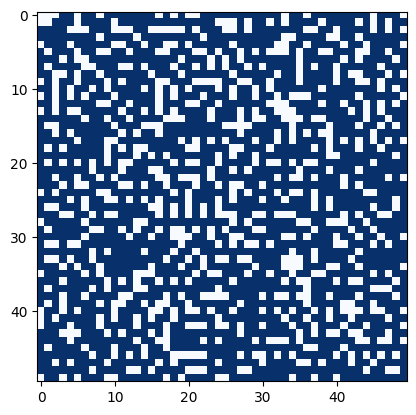

In [13]:
# Generate Ship
D = 50
ship = Ship(D)
ship.display()

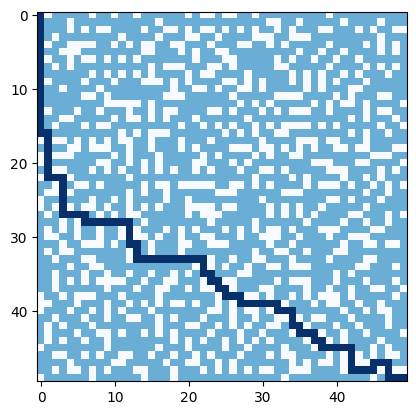

In [12]:
sorted_opens = sorted(ship.open_cells, key = lambda x : (x[0], x[1]))
a, b = sorted_opens[0], sorted_opens[-1]
#path = ship.has_path(a, b)
path = ship.shortest_path(a, b)
ship.display(path)